# Building CNN application to detect digits database MNIST

MNIST is a dataset consisting thousands of handwritten digits. In this Jupyter Notebook, we are going to use TensorFlow in building Convolutional Neural Networks in order to correctly identify the input image: '0', '1', '2', ..., '8', or '9'.

## 1. Loading libraries

In [2]:
import numpy as np
import pandas as pd
import struct
import sys
import os
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from datetime import datetime
%matplotlib inline

## 2. Settings

In [46]:
batch_size = 64
drop_out = 0.5
epoch_num = 20
width, height = 28, 28

## 3. Data preparation

Data is available on YanLecun website at `http://yann.lecun.com/exdb/mnist/`. There are four files for training and test data. There are also similar dataset on Kaggle website in the form of csv but I have decided to use the ones from the original source.

First, let's load our raw data which is saved in folder `data`. To make things easier, I already extracted the originals file and keep them in `data` folder. Then I adapted the code for loading them from the book for Python. As we can see that there are about 60k rows and 784 columns in training set and 10k rows for testing. The dimension of every image is of size 28 x 28 (which is 784 pixels in total). Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, the higher the number the darker the pixel is and those values are integers ranging between 0 and 255.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

Below is an example of a data row:

```java
  0   0   0   0 ...   0   0
247 127   0   0 ...   0   0
254 254 254 254 ... 082 083
 |   |   |   |  ...  |   |
 73  89  89  93 ...  18 232
  0   0   0   0 ...    0  0 
```

In [55]:
# Adapted from Chapter 15 of the book Python Machine Learning (Second Edition)
def load_mnist(path, kind="train"):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,"%s-labels-idx1-ubyte"% kind)
    images_path = os.path.join(path,"%s-images-idx3-ubyte"% kind)

    with open(labels_path, "rb") as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, "rb") as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [5]:
raw_data, raw_labels = load_mnist("./data", kind="train")
print("Train shape: {},  Train labels shape: {}".format(raw_data.shape, raw_labels.shape))
raw_test_data, raw_test_labels = load_mnist("./data", kind="t10k")
print("Test shape:  {},  Test labels shape:  {}".format(raw_test_data.shape, raw_test_labels.shape))

Train shape: (60000, 784),  Train labels shape: (60000,)
Test shape:  (10000, 784),  Test labels shape:  (10000,)


In [56]:
print("Sample data for row 10th: \n{}".format(raw_data[10]))

Sample data for row 10th: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  42 118 219
 166 118 118   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 103 242 254 254 254 254 254  66   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  18 232
 254 254 254 254 254 238  70   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 104 244 254 224 254 254 254 141   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 207 254 210 254

In [57]:
print("First 10 labels in train data: \n{}".format(raw_labels[0:20]))

First 10 labels in train data: 
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


### Formatting image data

We will get all pixel data and save it into an array. As all of the pixel values are from 0 to 255, we will convert them by dividing each by `255` with the help of function <span style="color:blue; font-family:Courier">convert_data</span>.

Please also note the datatype here is `np.float32`, later when we create TensorFlow Graph, datatype for placeholder training input `x` must be declared in the same type `tf.float32`.

In [7]:
def convert_data(data):
    '''
    Arguments:
        data: raw data
    Return:
        array in the form of float values
    '''
    img = data.astype(np.float32)
    return np.multiply(img, 1.0 / 255.0) # Convert from [0:255] to [0.0:1.0]

In [8]:
print("Converting raw train data...")
raw_converted_train_data = convert_data(raw_data)
print("Converting raw test data...")
raw_converted_test_data = convert_data(raw_test_data)
print("Done converting...")

Converting raw train data...
Converting raw test data...
Done converting...


Checking for the shape of train and test data:

In [9]:
print("Train Image shape: {}".format(raw_converted_train_data.shape))
print("Test Image shape: {}".format(raw_converted_test_data.shape))

Train Image shape: (60000, 784)
Test Image shape: (10000, 784)


Below is the value for our first image after convertion:

In [58]:
print("First image: \n{}".format(raw_converted_train_data[0]))

First image: 
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          

Let's define <span style="color:blue; font-family:Courier">display_image</span> function to show some images in our dataset.

In [11]:
def display_image(data, width, height):
    '''
    Arguments:
        data: data image
        width: the width of display image (which is 28)
        height: the height of display image (which is also 28)
    Return:
        plot containing 20 images of our first 20 digits
    '''
    fig = plt.figure(figsize=(7, 7))
    for i in range(1, 21):
        fig.add_subplot(4, 5, i)
        new_image = data[i-1].reshape(width, height)
        plt.imshow(new_image, cmap=cm.binary)
        plt.axis('off')

Our first 20 digits in the dataset:

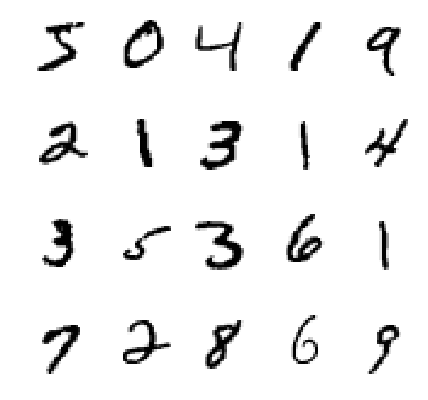

In [12]:
display_image(raw_converted_train_data,width,height)

Next, we will check to see how many classes are there for label in our dataset. As expected, there are 10 different labels which corresponding to our 10 digits from `0` to `9`. The first 20 digits match with our image plot above.

In [13]:
labels_count = np.unique(raw_labels)
print("Shape of labels: {}".format(raw_labels.shape))
print('Count for labels: {0}'.format(labels_count.shape[0]))
print("First 20 labels:{}".format(raw_labels[0:20]))

Shape of labels: (60000,)
Count for labels: 10
First 20 labels:[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


### Formatting labels data

Defining <span style="color:blue; font-family:Courier">convert_to_one_hot</span> function to convert labels values into the format of one-hot vectors. 

For example:
    
    Digit 0: [1 0 0 0 0 0 0 0 0 0]
    Digit 3: [0 0 0 1 0 0 0 0 0 0]

- We can also use pre-defined function `tf.one_hot` from TensorFlow to convert all labels into one-hot vectors. If you decide to use this method, when creating the graph, the shape for placeholder of labels `y` should be `[None]` as sample code below:

    ```python
    tf.one_hot(indices=tf_y, 
               depth=10,
               dtype=tf.float32,
               name="tf_y_onehot")

    tf_y = tf.placeholder(tf.int32, 
                          shape=[None],
                          name='tf_y')
    ```

- Or using the function <span style="color:blue; font-family:Courier">convert_to_one_hot</span> and `[None, 10]` for the labels `y` in Tensor graph. Here, we prefer this method.

In [59]:
def convert_to_one_hot(labels_data, max_length):
    '''
    Arguments:
        labels_data: our raw data containing labels values
        max_length: the maximum columns of our one-hot vectors (class numbers)
    Return: 
        Labels in the form of one-hot vectors
    '''
    label_binarizer = pre.LabelBinarizer()
    label_binarizer.fit(range(max_length))
    one_hot_label = label_binarizer.transform(labels_data)
    one_hot_label = one_hot_label.astype(np.int32)
    return one_hot_label

In [60]:
train_labels = convert_to_one_hot(raw_labels,10)
print("Shape of train labels: {}".format(train_labels.shape))
print("First 5 train labels: \n{}\n".format(train_labels[0:5]))

test_labels = convert_to_one_hot(raw_test_labels,10)
print("Shape of test labels: {}".format(test_labels.shape))
print("First 5 test labels: \n{}".format(test_labels[0:5]))

Shape of train labels: (60000, 10)
First 5 train labels: 
[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]

Shape of test labels: (10000, 10)
First 5 test labels: 
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


### Spliting data

Training data will be splitted into train and validation sets for training and validation purposes with the size of 15% of total for validation set and the rest for training set.

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(raw_converted_train_data, 
                                                    train_labels, 
                                                    test_size = 0.15, 
                                                    random_state = 123)

print("Length of x_train: "+ str(x_train.shape))
print("Length of y_train: "+ str(y_train.shape) +"\n")
print("Shape of x_valid: "+ str(x_valid.shape))
print("Shape of y_valid: "+ str(y_valid.shape))

Length of x_train: (51000, 784)
Length of y_train: (51000, 10)

Shape of x_valid: (9000, 784)
Shape of y_valid: (9000, 10)


### Batching training data

Defining function <span style="color:blue; font-family:Courier">batch_generator</span> to split data into batched before feeding into our graph.

In [17]:
# Adapted from Chapter 15 of the book Python for Machine Learning (Second Edition)
def batch_generator(X, y, batch_size=64, shuffle=True, random_seed=123):
    idx = np.arange(y.shape[0])
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

## 4. Building CNN model

### Structure

The basic CNN structure is as follows: 
    
    Convolution -> Pooling -> Convolution -> Pooling -> Fully Connected Layer -> Fully Connected Layer + softmax


<img src="./data/images/cnn.png" alt="Drawing" style="width: 75%;"/>

There are three main operations in the ConvNet shown in Figure above:

   - Convolution: Convolution is the act of taking the original data, and creating feature maps from it. The convolutional layers are not fully connected like a traditional neural network.
   - Pooling or Sub Sampling: Pooling is sub-sampling, most often in the form of “max-pooling,” where we select a region, and then take the maximum value in that region, and that becomes the new value for the entire region.
   - Classification (Fully Connected Layer): Fully Connected Layers are typical neural networks, where all nodes are “fully connected.”

These operations are the basic building blocks of every Convolutional Neural Network, so understanding how these work is an important step to developing a sound understanding of ConvNets. 

In this architecture, we use `SAME` paddiing. Output 32 and 64 feature maps for first and second convolutional layers respectively.

The dimensions of the tensors in each layer are as follows:
    
    - Input:                  [batchsize × 28 × 28 × 1]
    - Conv_1:                 [batchsize × 28 × 28 × 32]
    - Pooling_1:              [batchsize × 14 × 14 × 32]
    - Conv_2:                 [batchsize × 14 × 14 × 64]
    - Pooling_2:              [batchsize × 7 × 7 × 64]
    - FC_1:                   [batchsize × 1024]
    - FC_2 and softmax layer: [batchsize × 10]

### Weight initialization

Let's define 2 functions as below for weights with random value to prevent 0 gradients and small positive bias to avoid dead neurons.

In [18]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Convolution and Pooling

In this part, we will create another 2 functions for our convolution layer and max-pooling layer. Here, we will define our stride is 2, max-pooling is `2x2` with `same` padding.

In [63]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### TensorFlow Graph

In this part, we will apply the architecture in the figure above to define the TensorGraph.

In [ ]:
def build_cnn():
    '''
    Build TensorGraph
    
    Arguments:
        None
    Return:
        cross_entropy, train_step, accuracy, merged: which will be used as arguments for build_cnn() function
    '''
    # Define Placeholders
    tf_x = tf.placeholder(tf.float32, shape=[None, 784], name = "tf_x")
    tf_y = tf.placeholder(tf.int32, shape=[None, 10], name = "tf_y")
    tf_keep_prob = tf.placeholder(tf.float32, name = "fc_keep_prob")

    # Reshaped input x to 4D tensor with the second and third values are the width and height of image
    # the last value 1 means number of color channels
    x = tf.reshape(tf_x, [-1,28,28,1])
    # Layer 1: First Conv Layer
    # patch size: 5x5 ; input channel: 1 ; output channel: 32 features
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])

    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # Layer 2: Second Conv Layer
    # patch size: 5x5 ; input channel: 32 ; output channel: 64 features
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # Layer 3: First Fully Connected Layer
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Drop out
    h_fc1_drop = tf.nn.dropout(h_fc1, tf_keep_prob)

    # Layer 4: Second Fully Connected Layer with softmax activation function
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    # Apply Softmax function on the 2nd FC layer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_y, logits=y_conv), 
                                   name = "cross_entropy_loss")
    tf.summary.scalar("cost", cross_entropy)
    
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy) # train_op
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # acc
    tf.summary.scalar("accuracy", accuracy)
    merged = tf.summary.merge_all()
    
    return cross_entropy, train_step, accuracy, merged

## 5. Training CNN model

Defining function <span style="color:blue; font-family:Courier">train_cnn</span> to train our CNN model. We will train data in batches and validation to test the trained model. Later we select the best model that gives us highest accuracy.

In [27]:
def train_cnn(sess, g, x_train, y_train, x_valid, y_valid, epoch_num, ls, ac, op, merged, initialize):
    '''
    Train CNN model
    
    Arguments:
        sess: TensorFlow session
        g: TensorFlow graph
        x_train: training data
        y_train: training labels
        x_valid: validation data
        y_valid: validation labels
        epoch_num: number of training epoch
        ls: cross_entropy_loss from the graph
        ac: accuracy from the graph
        op: train_step from the graph
        merged: writer summary to display training loss and accuracy in TensorBoard
        initialize: set to True to train model from beginning by initializing all variables
    Return:
        The output will be a collection trained models for every epoch
    '''
    dt = datetime.now().strftime("%Y%m%d-%H%M%S")
    logdir = "./data/tensorboard/" + dt + "/"
    writer = tf.summary.FileWriter(logdir, g)
    iteration = 1
    
    # If initialize is True we will start to train from beginning
    # Else: Continue to train our selected model
    if initialize:
        sess.run(tf.global_variables_initializer())
    
    for epoch in range(1, epoch_num+1):
        train_loss = 0.0
        # Start timer
        tic = datetime.now()
        # Create batched for training data
        batch_train = batch_generator(x_train, y_train)
        for i,(batch_x,batch_y) in enumerate(batch_train):
            # Train and calculate loss for data
            feed = {"tf_x:0": batch_x, "tf_y:0": batch_y, "fc_keep_prob:0": drop_out}
            summary, loss, _ = sess.run([merged, ls, op], feed_dict=feed)
            # Write loss and accuracy data into TensorBoard writer
            writer.add_summary(summary, iteration)
            iteration +=1
            train_loss += loss
        # Calculate accuracy for validation data
        feed = {"tf_x:0": x_valid, "tf_y:0": y_valid, "fc_keep_prob:0":1.0}
        accuracy_valid = sess.run(ac, feed_dict=feed)
        # Print out average train loss and accuracy for validation data
        print("Epoch %02d: Avg train loss:  %7.3f | Valid acc:  %7.3f" % (epoch, (train_loss / (i+1)), accuracy_valid))
        # Save model every epoch
        saver.save(sess, "./data/model/cnn-model-{}.ckpt".format(epoch))
        # Stop timer
        toc = datetime.now()
        time = (toc - tic)
        print("Time: {}".format(time.seconds))
    writer.close()

Next, let's create a graph `g` and build the graph then initiate tensor session to train the model by calling function `train_cnn`.

In [28]:
g = tf.Graph()
with g.as_default():
    # Build the graph
    cross_entropy, train_step, accuracy, merged = build_cnn()
    # Create saver
    saver = tf.train.Saver(max_to_keep=None)

with tf.Session(graph = g) as sess:
    train_cnn(sess, g, x_train, y_train, x_valid, y_valid, epoch_num, 
              cross_entropy, accuracy, train_step, merged, True)
    

Epoch 01: Avg train loss:    0.741 | Valid acc:    0.958
INFO:tensorflow:./data/model/cnn-model-1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 291
Epoch 02: Avg train loss:    0.160 | Valid acc:    0.973
INFO:tensorflow:./data/model/cnn-model-2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 291
Epoch 03: Avg train loss:    0.110 | Valid acc:    0.978
INFO:tensorflow:./data/model/cnn-model-3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 273
Epoch 04: Avg train loss:    0.083 | Valid acc:    0.982
INFO:tensorflow:./data/model/cnn-model-4.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 284
Epoch 05: Avg train loss:    0.065 | Valid acc:    0.982
INFO:tensorflow:./data/model/cnn-model-5.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Time: 286
Epoch 06: Avg train loss:    0.055 | Valid acc:    0.985
INFO:tensorflow:./data/model/cnn-model-6.ckpt is not in all_model_checkpoint_paths. Manu

### Training accuracy and loss via TensorBoard

TensorBoard for Accuracy and the Cost during the training time after 20 epochs. 

<img src="./data/images/acc.png" alt="Accuracy" style="width: 65%;"/>


<img src="./data/images/cost.png" alt="Cost" style="width: 65%;"/>


## 6. Testing CNN model

Let's test our trained model with our test data.

In [135]:
def predict(sess, x_test, y_test, accuracy):
    '''
    Predict test data
    
    Arguments:
        sess: TensorFlow session
        x_test: test data
        y_test: test labels
        accuracy: accuracy from the graph
    Return:
        Accuracy value over test set
    '''
    feed = {'tf_x:0': x_test,
            "tf_y:0": y_test,
            'fc_keep_prob:0': 1.0}
    
    return sess.run(accuracy, feed_dict=feed)

In [62]:
g2 = tf.Graph()
with g2.as_default():
    # build the graph
    cross_entropy, train_step, accuracy, merged = build_cnn()
    saver = tf.train.Saver()
with tf.Session(graph = g2) as sess:
    # Restore our saved model
    saver.restore(sess, "./data/model/cnn-model-20.ckpt")
    # Use predict function to get the result
    print("Accuracy with test set: ", predict(sess, raw_converted_test_data, test_labels, accuracy))

Accuracy with test set:  0.9912


We can try to continue training our model for five more epochs and do the testing again.

In [36]:
with tf.Session(graph=g2) as sess:
    # Restore our saved model
    saver.restore(sess, "./data/model/cnn-model-20.ckpt")
    # Continue to train from 20th model
    train_cnn(sess, g2, x_train, y_train, x_valid, y_valid, 5, 
              cross_entropy, accuracy, train_step, merged, False)

Epoch 01: Avg train loss:    0.008 | Valid acc:    0.990
Time: 344
Epoch 02: Avg train loss:    0.008 | Valid acc:    0.989
Time: 297
Epoch 03: Avg train loss:    0.007 | Valid acc:    0.990
Time: 279
Epoch 04: Avg train loss:    0.006 | Valid acc:    0.989
Time: 297
Epoch 05: Avg train loss:    0.006 | Valid acc:    0.991
Time: 285


Rename model, model 24 is the best 99,27%

In [45]:
with tf.Session(graph = g2) as sess:
    saver.restore(sess, "./data/model/cnn-model-24.ckpt")
    print("Accuracy with test set: ", predict(sess, raw_converted_test_data, test_labels, accuracy))

Accuracy with test set:  0.9927


# References

1. https://www.tensorflow.org/versions/r1.0/get_started/mnist/beginners
2. https://www.tensorflow.org/versions/r1.0/get_started/mnist/pros
3. http://suruchifialoke.com/2017-06-17-predicting-digits-cnn-tensorflow/
4. http://yann.lecun.com/exdb/mnist/
5. https://colah.github.io/posts/2014-07-Conv-Nets-Modular/
6. http://neuralnetworksanddeeplearning.com/chap6.html
7. https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning-second-edition